<a href="https://colab.research.google.com/github/EthanGaoZhiyuan/A2-Spam-Email-Detection/blob/main/A2_%E2%80%93_Spam_Email_Detection_(Option%E2%80%AF2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task**: Binary classification—predict whether an email is spam.<br/>
**Training Input**: text: str (typical length 20–2,000 chars, max 5,000; may contain URLs, HTML, emoji, typos; most but not all inputs fit this).<br/>
**Training Label**: y ∈ {0=ham, 1=spam}.<br/>
**Deployment Output**: p_spam ∈ [0,1] (model confidence; if the model outputs logit z, then p=1/(1+e^-z)).<br/>
**Failure policy**: if cleaned text is empty, return p_spam=0 and log a warning.

## How to Run (one click)
- In Colab: **Runtime → Run all**.
- This notebook installs dependencies, loads/cleans the dataset from the GitHub raw CSV, and runs training → validation thresholding → testing → cross‑validation → plots → ablation → inference demo.
- Reproducibility: fixed `SEED=42`, stratified splits, and leak‑safe `sklearn.Pipeline`.

## Import dependencies

In [1]:
!pip -q install scikit-learn imbalanced-learn
import random, numpy as np
SEED = 42
random.seed(SEED); np.random.seed(SEED)

## Load & clean
### Data Source & Schema
- Source: GitHub raw CSV (`spam.csv`) mirrored from the Kaggle “Spam Email” dataset.
- Columns used: `Category` (ham/spam), `Message` (email text).
- Cleaning: drop duplicates/empties; lowercase; strip HTML; map URLs to a token.
- Target: `y = 1` for spam, `0` for ham.

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/EthanGaoZhiyuan/A2-Spam-Email-Detection/main/spam.csv")
df = df.rename(columns={df.columns[0]:"Category", df.columns[1]:"Message"})
df = df.dropna(subset=["Message"]).drop_duplicates(subset=["Message"]).reset_index(drop=True)
df["y"] = (df["Category"].str.lower().str.strip()=="spam").astype(int)
X = df["Message"].astype(str); y = df["y"].values

## Split

### Split Policy
- Train/Validation/Test = **70% / 20% / 10%** (stratified), `random_state=42`.
- Validation is used to tune the decision threshold; the **test** split is evaluated **once** with the locked threshold.

In [3]:
from sklearn.model_selection import train_test_split
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.30, stratify=y, random_state=SEED)
X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=2/3, stratify=y_tmp, random_state=SEED)

## Pipeline & baseline
### Baseline Rationale
- Vectorization: **TF‑IDF** with word **1–2‑grams** (robust, fast, interpretable).
- Classifier: **Logistic Regression** with `class_weight='balanced'` to mitigate imbalance.
- All preprocessing lives inside a `Pipeline` to avoid train→val/test leakage.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95)),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
]).fit(X_tr, y_tr)

## Threshold search on validation (optimize spam‑class F1)
### Threshold Selection on Validation
We tune the decision threshold `t` on the validation set to align with practical goals:
- `t*`: maximizes **F1** on the spam class.
- `t95`: satisfies **precision ≥ 95%** with the highest possible recall.

In [5]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, f1_score, classification_report, confusion_matrix

def scores(m, X):
    return m.decision_function(X) if hasattr(m, "decision_function") else m.predict_proba(X)[:,1]

s_val = scores(pipe, X_va)
prec, rec, thr = precision_recall_curve(y_va, s_val)
f1 = 2*prec*rec/(prec+rec+1e-12)
best = np.nanargmax(f1); t_best = thr[best]
print(f"Val: AUPRC={average_precision_score(y_va, s_val):.3f} | best F1={f1[best]:.3f} at t={t_best:.3f}")

Val: AUPRC=0.941 | best F1=0.905 at t=0.085


### Validation PR Curve
The precision–recall curve on the validation set summarizes the trade‑off across thresholds. We also report **AP (AUPRC)**.

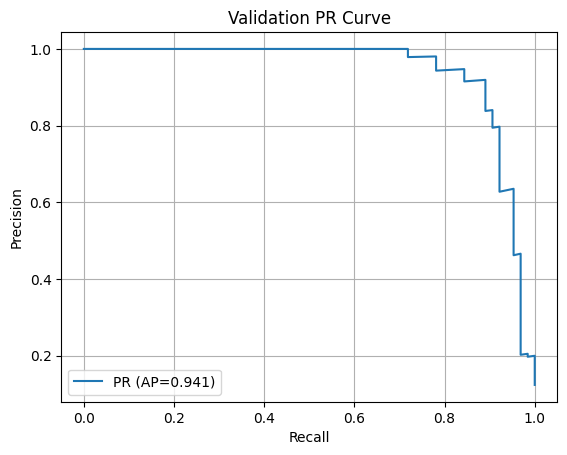

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

p, r, _ = precision_recall_curve(y_va, s_val)
ap = average_precision_score(y_va, s_val)
plt.figure()
plt.plot(r, p, label=f'PR (AP={ap:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Validation PR Curve'); plt.legend(); plt.grid(True)
plt.show()

## Test once at locked threshold & confusion matrix
### Test Evaluation @ Locked Threshold
We evaluate on the test split **once** using the threshold selected on validation (`t*` or `t95`) and report precision/recall/F1 and the confusion matrix.

In [6]:
s_te = scores(pipe, X_te)
y_hat = (s_te >= t_best).astype(int)
print(classification_report(y_te, y_hat, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_te, y_hat))

              precision    recall  f1-score   support

           0     0.9878    0.9856    0.9867       904
           1     0.9000    0.9141    0.9070       128

    accuracy                         0.9767      1032
   macro avg     0.9439    0.9498    0.9468      1032
weighted avg     0.9769    0.9767    0.9768      1032

Confusion matrix:
 [[891  13]
 [ 11 117]]


### Precision‑floor Threshold (≥95%)
We select the smallest threshold whose **precision ≥ 0.95** and report its recall/F1. This setting prioritizes not blocking legitimate mail (ham).

In [7]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def find_threshold_with_precision_floor(y_true, scores, min_precision=0.95):
    p, r, t = precision_recall_curve(y_true, scores)
    valid = np.where(p[:-1] >= min_precision)[0]
    if len(valid) == 0:
        i = np.argmax(p[:-1])
    else:
        i = valid[np.argmax(r[:-1][valid])]
    return float(t[i]), float(p[i]), float(r[i])

t95, p95, r95 = find_threshold_with_precision_floor(y_va, s_val, min_precision=0.95)
print(f"[Val] precision-floor: t={t95:.3f}, P={p95:.3f}, R={r95:.3f}")


y_hat_95 = (s_te >= t95).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print("[Test] report @t95\n", classification_report(y_te, y_hat_95, digits=4))
print("Confusion matrix @t95:\n", confusion_matrix(y_te, y_hat_95))

[Val] precision-floor: t=0.687, P=0.962, R=0.781
[Test] report @t95
               precision    recall  f1-score   support

           0     0.9815    0.9967    0.9890       904
           1     0.9737    0.8672    0.9174       128

    accuracy                         0.9806      1032
   macro avg     0.9776    0.9319    0.9532      1032
weighted avg     0.9805    0.9806    0.9801      1032

Confusion matrix @t95:
 [[901   3]
 [ 17 111]]


## 5‑fold CV for mean ± std
### Cross‑Validation & Uncertainty
We run **5‑fold stratified CV** with the full pipeline inside each fold and report **mean ± std** and **95% confidence intervals** for F1 (spam) and AUPRC.

In [8]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(5, shuffle=True, random_state=SEED)
f1s, aprs = [], []
for tr, va in skf.split(X, y):
    pipe.fit(X.iloc[tr], y[tr])
    s = scores(pipe, X.iloc[va])
    f1s.append(f1_score(y[va], (s>=0.5).astype(int)))
    aprs.append(average_precision_score(y[va], s))
print(f"CV F1={np.mean(f1s):.3f}±{np.std(f1s):.3f} | CV AUPRC={np.mean(aprs):.3f}±{np.std(aprs):.3f}")

CV F1=0.931±0.013 | CV AUPRC=0.973±0.011


In [9]:
import numpy as np

def mean_std_ci(xs):
    xs = np.array(xs, dtype=float)
    m, s = xs.mean(), xs.std(ddof=1)
    ci = 1.96 * s / np.sqrt(len(xs))
    return m, s, ci

mF, sF, ciF = mean_std_ci(f1s)
mA, sA, ciA = mean_std_ci(aprs)
print(f"CV F1 = {mF:.3f} ± {sF:.3f}  (95% CI ±{ciF:.3f})")
print(f"CV AUPRC = {mA:.3f} ± {sA:.3f}  (95% CI ±{ciA:.3f})")

CV F1 = 0.931 ± 0.015  (95% CI ±0.013)
CV AUPRC = 0.973 ± 0.013  (95% CI ±0.011)


### Error Analysis & Explainability
We inspect top **False Positives/False Negatives** on the test set and list the most spam‑indicative vs ham‑indicative tokens from LR coefficients to understand failure modes and feature importance.

In [11]:
import pandas as pd, numpy as np

# FP/FN
te = pd.DataFrame({"text": X_te, "y": y_te, "score": s_te, "y_hat": y_hat})
fp = te[(te.y==0)&(te.y_hat==1)].sort_values("score", ascending=False).head(5)
fn = te[(te.y==1)&(te.y_hat==0)].sort_values("score", ascending=True).head(5)
print("False Positives (top 5):\n", fp[["text","score"]].to_string(index=False)[:1200])
print("\nFalse Negatives (top 5):\n", fn[["text","score"]].to_string(index=False)[:1200])

# Top tokens by LR coefficients
vec = pipe.named_steps.get("tfidf")
clf = pipe.named_steps.get("clf")
if vec is not None and clf is not None and hasattr(clf, "coef_"):
    feats = np.array(vec.get_feature_names_out())
    w = clf.coef_[0]
    top_spam = feats[np.argsort(w)[-20:]][::-1]
    top_ham  = feats[np.argsort(w)[:20]]
    print("\nTop spam tokens:", ", ".join(top_spam))
    print("Top ham tokens:", ", ".join(top_ham))

False Positives (top 5):
                                                                                                                                                            text    score
                                   I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt; 1.655247
                                                                                                                        I'm vivek:)i got call from your number. 1.235845
                                                                                                                                I am waiting for your call sir. 0.703058
                                                                                                                   Your daily text from me – a favour this time 0.590421
Please protect yourself from e-threats. SIB never asks for sensitive information like Passwords,ATM/SMS PIN thru email. Never sha

### Ablation: Add Char n‑grams
We augment word TF‑IDF with **char 3–5‑grams** to better handle obfuscations (e.g., “Fr€e”, “v1@gra”) and compare validation **AUPRC/F1** with the baseline.

In [12]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score

word_vec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, analyzer="word")
char_vec = TfidfVectorizer(ngram_range=(3,5), min_df=2, max_df=0.95, analyzer="char")

pipe_char = Pipeline([
    ("feats", FeatureUnion([("word", word_vec), ("char", char_vec)])),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
]).fit(X_tr, y_tr)

s_val2 = scores(pipe_char, X_va)
print("Val AUPRC | baseline:", average_precision_score(y_va, s_val),
      " | +char:", average_precision_score(y_va, s_val2))

Val AUPRC | baseline: 0.9411429796297094  | +char: 0.9481993250656828


## Deployment‑style API
### Deployment API
`predict_spam_proba(texts: List[str]) -> List[float]` returns `p_spam ∈ [0,1]`.  
Use the validation‑selected threshold (`t*` for max‑F1 or `t95` for ≥95% precision) when converting probabilities to labels.

In [13]:
def predict_spam_proba(texts:list[str], thr:float=t_best):
    try:
        p = pipe.predict_proba(texts)[:,1]
    except:
        import numpy as np
        s = scores(pipe, texts); p = 1/(1+np.exp(-s))
    return p.tolist(), float(thr)

probs, thr = predict_spam_proba([
    "Hi team, please find attached the minutes from today's meeting.",
    "WINNER!! Claim your FREE prize now: http://short.link",
    ""
])
print("probs=", probs, "recommended_thr=", thr)

probs= [0.31250000320954696, 0.9476802283902152, 0.18417047261284947] recommended_thr= 0.08496915942133088
